In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib

from typing import List, Tuple

# Time-Evolution of a Gaussian Wavepacket through a Rectangular Potential Barrier

In this notebook, we simulate a well-known problem in quantum mechanics: the time-evolution of a particle through a rectangular potential well. This problem is often addressed in introductory courses on quantum mechanics because it can be solved analytically, offering insight into a curious and peculiar behavior of quantum particles known as **tunneling** over a potential barrier.

In classical mechanics, a particle with a given kinetic energy $K$ cannot surpass a potential barrier $𝑉$, with $V>K$. For example, if there is a hill at 
$x$ representing a certain potential energy $V(x)$, a ball with kinetic energy $K$ moving towards the hill will never surpass it if $K<V(x)$. However, according to quantum mechanics, the particle must be represented by a *wavefunction*, which is defined over the entire space. When the wavefunction encounters the potential barrier (the hill), it can be demonstrated that there will always be a non-zero probability of finding the particle beyond it. In particular, this probability is significant if the width of the wavepacket is greater than the width of the barrier.

In the following sections, we will provide a theoretical introduction to the problem, briefly discussing the properties of Gaussian wavepackets, their time-evolution, and how to calculate tunneling probabilities. Subsequently, we will write code to simulate the system and generate an animation demonstrating tunneling phenomena.

## Gaussian wavepacket

Let consider the time-independent Schrodinger equation for a free particle in 1D:
$$
-\frac{\hbar^2}{2m}\frac{d\psi}{dx^2} = \epsilon \psi
$$
We know that a function solving such kind of differential equations can be choosen in the following form:
$$
\psi(x) \propto e^{\pm i\alpha x}
$$
From this ansatz, we find that $\epsilon = (\hbar \alpha)^2/(2m)$, therefore if $(\hbar \alpha)$ is a momentum, $p$, then $\epsilon = p^2/2m$ is the kinetic energy of the particle. Actually, $\hbar \alpha = p$, if $\alpha$ is the wave-vector $k$; therefore, the "true" solution of the above equation becomes $e^{\pm ikx}$, i.e. a *plane wave* propagating with wavevector $k$. We are interested in a *time-dependent* problem, i.e. we want to solve the following **time-dependent Schrodinger equation**:
$$
i\hbar\frac{\partial \Psi}{\partial t} = H\Psi
$$
Since $\epsilon \psi$ is a time-indendepent term, we can assume the solution $\Psi$ to be of the form $\Psi(x,t)=\psi(x)\chi(t)$, therefore:
$$
i\hbar\frac{\partial \chi}{\partial t} = -\frac{\hbar^2k^2}{2m}\chi(t)
$$
that can be solved to give:
$$
\chi(t)=\chi(0) e^{-it\frac{\hbar k^2}{2m}}
$$
Hence, we can write the final solution as $\Psi(x,t) = \exp(ikx)\exp\left(-it \frac{\hbar k^2}{2m}\right)$. However, in general our wavefunction will be a superposition of plane waves of different wavevectors $k_i$, therefore a more complete solution is given by:
$$
\Psi(x,t) = \int_{-\infty}^{+\infty} a(k) \exp(ikx)\exp\left(-it \frac{\hbar k^2}{2m}\right) dk
$$
Notice that we have used a "continuous sum", i.e. an integral over $k$, because a *free* particle is characterized by a continuous energy spectrum. The above equation can be considered as a general form for a wavepacket represeting a free particle and can be easily generalized to more dimension. However, let's stick to the 1D case and let choose the term $a(k)$ to give the wavepacket a specific form. In particular, we can find $a(k)$ so that the wavefunction has a **Gaussian** form at time 0, representing then a sort of *localized* particle, depending on its variance. In particular, we set:
$$
\Psi(x,0) = Ne^{-ax^2}
$$
where $N$ is a normalization costant. At time 0, the time-dependent Schrodinger equation reads as:
$$
Ne^{-ax^2} = \int_{-\infty}^{+\infty}a(k)e^{ikx}dk
$$
multiplying both sides by $e^{-ik'x}$ and integrating over $dx$:
$$
\begin{gather}
\int_{-\infty}^{+\infty}e^{-ik'x}Ne^{-ax^2}dx = \int_{-\infty}^{+\infty} dk \int_{\infty}^{+\infty}e^{i(k-k')x}a(k)dx \\
N\int_{-\infty}^{+\infty} e^{-ax^2-ik'x}dx = 2\pi \int_{-\infty}^{+\infty} \delta(k-k')a(k)dk = 2\pi a(k')
\end{gather}
$$
The term on the left side can be integrated analytically. We skip here the simple but lenghty calculation, to give the final result:
$$
a(k') = N \sqrt{\frac{1}{4\pi a}} \exp\left( -\frac{k'^2}{4a}\right)
$$
Therefore, we can write our Gaussian wavepacket as:
$$
\Psi(x,t) =  N \sqrt{\frac{1}{4\pi a}} \int_{-\infty}^{+\infty} \exp\left( -\frac{k^2}{4a}\right) \exp(ikx)\exp\left(-it \frac{\hbar k^2}{2m}\right) dk
$$
The Gaussian integral over $k$ can be solved analytically. Again, we skip such calculations to give the final result in a more coincise form:
$$
\Psi(x,t) = N\exp\left(-\alpha_t x^2\right)\exp\left(i\frac{\gamma_t}{\hbar}\right)
$$
where
$$
\begin{gather}
\alpha_t = \frac{a}{1+(2i\hbar ta)/m} \\
\gamma_t = -\frac{\hbar}{2i}\ln\left(1+\frac{2i\hbar ta}{m}\right)
\end{gather}
$$
Therefore, it suffices to know the initial Gaussian amplitude $a$ to have the wavepacket evolution at each time. Let write a Python function to plot the wavepacket at a given time to show its form:

In [2]:
# Defining a grid of points
x = np.linspace(0,1000,1001)

In [3]:
def approx_integral(f, dx, axis = 0) -> float:
    '''
    Function to approximate integral in discrete space

    :params f: the function (y) values a np.array
    :params dx: the discrete differential 

    :returns: a float representing the approximate integral of f(x)dx
    '''
    return np.sum(f*dx, axis = axis)

In [4]:
# The differential given the initial x
dx = x[1]-x[0]

Now we define two functions to compute $\alpha_t$ and $\gamma_t$. For simplicity, we set $\hbar = m = 1$.

In [5]:
def get_alpha(t: float, a: float):
    '''
    :params t: time
    :params a: the Gaussian amplitude
    '''
    return a/(1+2j*t*a)
    
def get_gamma(t: float, a: float):
    '''
    :params t: time
    :params a: the Gaussian amplitude
    '''
    return -(1/2j)*np.log(1+2j*t*a)

In [6]:
# Setting wavepacket properties
x0 = 500
t = 10
a = 100

In [7]:
# Computing the wavepacket and normalizing
Psi = np.exp(-get_alpha(t, a)*(x[1:-1]-x0)**2)*np.exp(1j*get_gamma(t,a))
norm = approx_integral(Psi, dx)

Psi = Psi/norm

In [8]:
# Extracting the real and imaginary part
Psi_real = np.real(Psi) 
Psi_imag = np.imag(Psi)

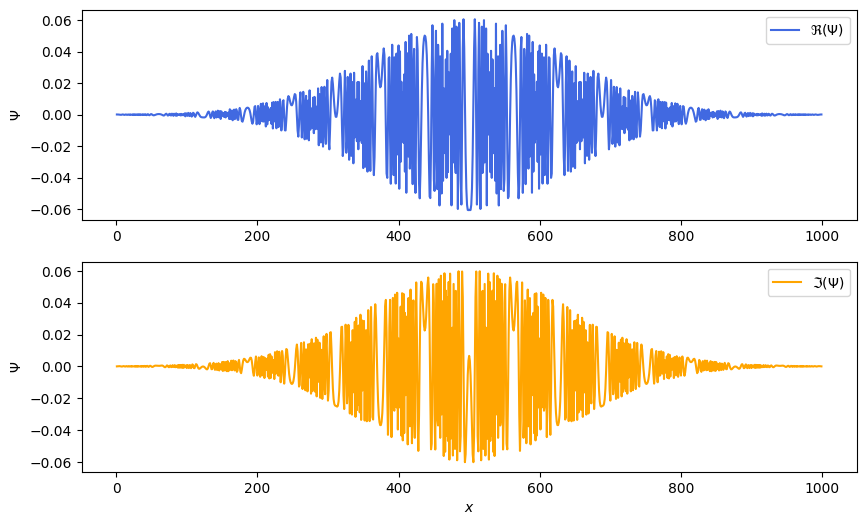

In [9]:
# Plotting 
fig, ax = plt.subplots(2, 1, figsize=(10,6))

ax[0].plot(x[1:-1], Psi_real, color="royalblue", label=r'$\Re(\Psi)$')
ax[1].plot(x[1:-1], Psi_imag, color="orange", label=r'$\Im(\Psi)$')

ax[1].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$\Psi$')
ax[1].set_ylabel(r'$\Psi$')

ax[0].legend()
ax[1].legend()
plt.show()

## Quantum Tunneling

Let now suppose that a quantum particle is traveling in a given direction $x$ with kinetic energy $E$ and encounters a potential barrier described by Equation the following equation:
$$
V(x) = \begin{cases}
V_0 \ \ \text{if} \ \ a < x < a+L \\
0 \ \ \text{otherwise}
\end{cases}
$$
i.e. describing a rectangular potential barrier. What is the probability that the particle will tunnel through the potential barrier? The answer can be found by solving a boundary-value problem for the time-independent Schrӧdinger equation similarly to the one defined above:
$$
-\frac{\hbar^2}{2m}\frac{d\psi}{dx^2} + V(x)\psi(x) = \epsilon \psi(x)
$$
We assume that the given energy $E$ of the incoming particle is smaller than the height $V_0$ of the potential barrier, since this is the interesting physical case. Our task is to solve the above Schrodinger equation, looking for a solution that must be continiuous and possess continuous first derivative at all $x$, i.e. also at the boundary regions. In addition, the final solution must be given a probabilistic interpretation, namely $|\psi(x)|^2$ should be a probability density. 

Defining as 1, 2 and 3 the three different regions of the space (see the image below), we could write the following three differential equations:
$$
\begin{gather}
-\frac{\hbar^2}{2m}\frac{d\psi_1}{dx^2} = \epsilon \psi_1(x) \\
-\frac{\hbar^2}{2m}\frac{d\psi_2}{dx^2} + V(x)\psi_2(x) = \epsilon \psi_2(x) \\
-\frac{\hbar^2}{2m}\frac{d\psi_3}{dx^2} = \epsilon \psi_3(x)
\end{gather}
$$

The boundary conditions are: $\psi_1(0) = \psi_2(0)$, $\psi_2(L) = \psi_3(L)$ and similarly for the first derivatives. According to the discussion about wavepackets done before, in region 1 and 3 we can assume the solution of the equation to be in the following form:
$$
\begin{gather}
\psi_1(x) = Ae^{ikx}+Be^{-ikx} \\
\psi_3(x) = Fe^{ikx}+Ge^{-ikx} 
\end{gather}
$$
In region 1, there are two waves: one is **incident** (moving to the right) and one is **reflected** (moving to the left). Therefore, none of the constants $A$ and $B$ may vanish. On the other hand, in region 3, there is only one wave, moving to the right, which is the **transmitted** wave, so the constant $G$ must be zero. The amplitude of the incident wave will be:
$$
|\psi_{inc}(x)|^2 = |A|^2
$$
while that of the transmitted wave will:
$$
|\psi_{trans}(x)|^2 = |F|^2
$$
What we would like to know is how much of the incident wave tunnels through the barrier, therefore we are interested in the following ration known as the **tunneling probability**:
$$
\tau(L, E) = \left|\frac{F}{A}\right|^2
$$
where we have made explicit the dependence of $\tau$ on $L$, the width of the barrier, and $E$ the energy of the particle. 

Let's now focus on region 2. Here, we can re-write the Schrodinger equation in the following form:
$$
\frac{d \psi_2}{dx^2} = \beta^2 \psi_2(x)
$$
with $\beta^2 = (2m/\hbar^2)(V_0-E)$. Unlike other regions, this equation has a solution of different form:
$$
\psi_2(x) = Ce^{-\beta x}+De^{+\beta x}
$$
namely, this solution does not display an oscillatory behavior (note the absence of the imaginary unit $i$) but describes an *attenuation* term. 

Now, exploiting the boundary conditions and with a little bit of algebra, one can arrive at the following formula:
$$
\frac{F}{A} = \frac{e^{ikL}}{\cosh(\beta L)+i(\gamma/2)\sinh(\beta L)}
$$
where $\gamma = \beta/k - k /\beta$. Therefore, the tunneling probability is then given by:
$$
\tau(L,E) = \frac{1}{\cosh^2(\beta L)+(\gamma/2)^2\sinh^2(\beta L)}
$$
From the above equation we can see that the tunneling effect strongly depends on the width $L$ of the potential barrier. In many situations, the barrier width $L$ is much larger than the decay length of the penetrating wave. In this case, the following approximation holds:
$$
\tau(L, E) \approx 16\frac{E}{V_0}\left(1-\frac{E}{V_0}\right)e^{-2\beta L}
$$


Let's compute the tunneling probabilities for different values of $L$ and $E$!

In [10]:
# First we compute different tunneling probabilities at different energies for different several L values, keeping fixed the potential width
V0 = 10                   # eV
E_c = np.linspace(1,10,200) # eV
L_d = np.linspace(1,8,8)    # nm

# "d" stands for "discrete", "c" for continuous --> here we want to plot tau(E_c)

Instead of working with eV and nanometers, let's switch to **atomic units**, where we use *Hartree* to measure energy and *Bohr radii* to measure lenghts. This system of units has two main advantages: first of all, the electron mass and the Planck constant are both equal to 1, $m=\hbar=1$, simplyfing the tunneling probability expression; in addition, in such units, the exponent $\beta L$ will be much larger, and taking the exponention will not cause issues about numerical precision.

In [11]:
# Convert to atomic units
ev_to_au = 1/27.211
nm_to_au = 1/0.529

In [12]:
E_au_c = E_c * ev_to_au
L_au_d = L_d * nm_to_au
V0_au = V0 * ev_to_au

In [13]:
def compute_tunneling(V0, E, L):
    beta = np.sqrt(2 * (V0 - E))
    return 16 * (E / V0) * (1 - E / V0) * np.exp(-2*beta*L)

In [14]:
tau_vs_E_L_dict = {}
for i, Li in enumerate(L_au_d):
    
    energy_curve = [compute_tunneling(V0_au, E, Li) for E in E_au_c]

    tau_vs_E_L_dict[L_d[i]] = energy_curve

Let also compute the tunneling probabilities as function of the barrier width:

In [15]:
# Now we fix the lenght of the barrier
E_d = np.arange(1,10)
L_c = np.linspace(1,8,200)

In [16]:
# Convert to atomic units
E_au_d = E_d * ev_to_au
L_au_c = L_c * nm_to_au

In [17]:
tau_vs_L_E_dict = {}
for i, Ei in enumerate(E_au_d):
    
    lenght_curve = [compute_tunneling(V0_au, Ei, L) for L in L_au_c]

    tau_vs_L_E_dict[E_d[i]] = lenght_curve

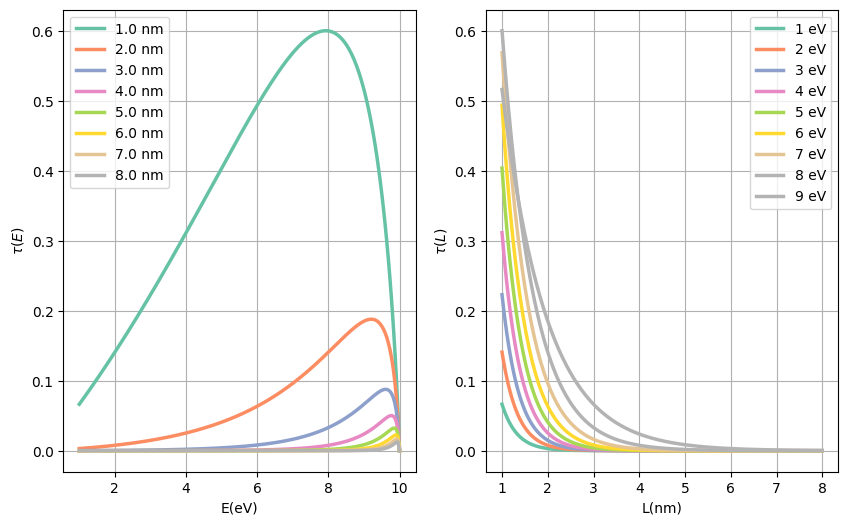

In [18]:
# Plot each line for each key
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Get the Pastel1 color map
pastel_colors = matplotlib.colormaps.get_cmap('Set2')

for i, (L_val, tauE) in enumerate(tau_vs_E_L_dict.items()):
    ax[0].plot(E_c, tauE, label=f"{L_val} nm", color=pastel_colors(i/len(tau_vs_E_L_dict)), lw=2.5)
for i, (E_val, tauL) in enumerate(tau_vs_L_E_dict.items()):
    ax[1].plot(L_c, tauL, label=f"{E_val} eV", color=pastel_colors(i/len(tau_vs_E_L_dict)), lw=2.5)
    
# Add labels and legend
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('E(eV)')
ax[1].set_xlabel('L(nm)')
ax[0].set_ylabel(r'$\tau(E)$')
ax[1].set_ylabel(r'$\tau(L)$')

# Show plot
plt.show()

We see from the above estimates that the tunneling probability is affected much more by the width of the potential barrier rather than by the energy of the incident particle. 

## Simulating the quantum tunneling 

It's now the time to make a simulation of a quantum particle traveling in the direction of a potential energy barrier and see the quantum tunneling in action. For this simulation we will make use of a simplified expression of the Gaussian wavepacket. Namely, we will assume that time 0, the wavepacket has the following form:
$$
\Psi(x, 0) \propto \exp\left(-a(x-x_0)^2\right)\exp(ik_0x)
$$
where $a = 1/(2\sigma^2)$, with $\sigma^2$ the Gaussian variance. The Gaussian wavepacket is centered at $x_0$ and has an initial momentum of $k_0$. The time-independent Shrodinger equation governing the system will be:
$$
H\psi = \left[-\frac{d^2}{dx^2} + V(x)\right]\psi(x) = \epsilon \psi(x)
$$
where again we are using atomic units. $V(x)$ will again be taken in the form of a rectangular potential barrier:
$$
V(x) = \begin{cases}
V_0 \ \ \text{if} \ \ a < x < a+L \\
0 \ \ \text{otherwise}
\end{cases}
$$
For the second-order differential operator, we will use a discrete approximation given by:
$$
\frac{d^2}{dx^2} = \frac 1{\Delta_x^2} 
\begin{pmatrix} 
-2 & 1 & 0 & 0 & \ldots \\
1 & -2 & 1 & 0 & \ldots \\
\vdots & \ddots & \ddots &  \ddots & \ddots \\
0 &\ldots & \ldots & 1 & -2 \\
\end{pmatrix} 
$$ 

The steps we are going to code can be summarized as follows:
- We define the initial wavepacket $\Psi(x,0)$ and normalize it;
- We solve the time-independent Schrodinger equation, diagonalizing the *Hamiltonian* operator to find the eigenfunctions $\psi_n$ and the corresponding eigenvalues $E_n$;
- Since the eigenfunctions form an orthonormal basis, we expand our Gaussian wavepacket into such basis as follow: $$\Psi(x, 0) = \sum_n c_n \psi_n$$ where the expansion coefficients are given by $$ c_n = \int_0^L \psi_n^{\star}\Psi(x,0)dx$$
- finally, we makes the wavepacket evolving in time, applying the **time-evolution operator**.

In regard to the last point, it is worth briefly recalling the basics of time-evolution in quantum mechanics. The time-evolution operator $U_t$ is a linear operator such that, given a quantum state $|psi_0\rangle$ at time 0:
$$
|\psi_t\rangle = U_t |\psi_0\rangle
$$
This operator must be isometric (it must conserve the quantum state norm at each time) and suriettive (each state must "have a past"), therefore it is a *unitary operator*. Taking the derivative w.r.t. $t$ and exploting some operator properties, one can prove that 
$$\frac{dU_t}{dt}U^T_t = -\frac{i}{\hbar}H
$$
and therefore that
$$
-\frac{i}{\hbar} H |\psi_t\rangle = \frac{d|\psi_t\rangle}{dt}
$$
which is nothing but the time-dependent Schrodinger equation. $H$ is an adjoint operator and it must be the "Hamiltonian" of the system. Indeed, for infinitesimal $\delta t$ , the above equation reduces to
$$
U_{\delta t} \approx 1 - \frac{1}{\hbar}H\delta t
$$
which shows that $H$ is the generator of the translations in time. We skip here some calculations since a complete description of the time-evolution operator is beyond the scope of this notebook, but we mention here the interesting result for our simulation. Namely, that the time-evolution operator can be given the following form:
$$
U(t,t_0) = \exp\left(-\frac{1}{\hbar}H(t-t_0)\right)
$$
Therefore, applying such operator to our expanded Gaussian wavepacket, we have a complete representation of the particle at each time, given by;
$$
\Psi(x,t) = U(t)\Psi(x,0) = \sum_n c_n e^{-iHt}\psi_n (x) = \sum_n e^{-iE_nt}\psi_n(x)
$$
where we have set again $\hbar=1$.

In [19]:
# Here we define the basic simulation parameters
# Time array
t_array = np.linspace(0.,2500,1000)

# Number of grid points along the x axis
N_grid = 750 

# The x position of the barrier, the lenght of the barrier and the potential energy
a = 420
L = 50
V0 = 0.1

# The initial position, the initial momentum and the standard deviation of the Gaussian wavepacket
x0 = 100
k0 = 0.4
sigma = 15

In [20]:
# Let build a class wrapping up the main methods to define the Gaussian wavepacket state and its time evolution:
class GaussianWavepacket():
    def __init__(self, N_grid: int, x0: float, k0: float, sigma: float):
        self.N_grid = N_grid
        self.x0 = x0
        self.k0 = k0
        self.sigma = sigma

        self.x = np.linspace(0, self.N_grid, self.N_grid+1)
        self.dx = self.x[1]-self.x[0]

    @staticmethod
    def approx_integral(f, dx, axis = 0) -> float:
        '''
        Function to approximate integral in discrete space
    
        :params f: the function (y) values a np.array
        :params dx: the discrete differential 
    
        :returns: a float representing the approximate integral of f(x)dx
        '''
        return np.sum(f*dx, axis = axis)


    def get_initial_state(self):
        '''
        Function to define the initial state of the Gaussian wavepacket
        '''

        Psi0  = np.exp( -1/2* (self.x[1:-1]-self.x0)**2/self.sigma**2) *np.exp(1j*self.k0*self.x[1:-1]) 

        # Computing the norm
        norm = self.approx_integral(np.abs(Psi0)**2, self.dx)
        
        return Psi0/np.sqrt(norm)

    def diagonalize_hamiltonian(self, H: np.array) -> Tuple[np.array]:
        '''
        Function to diagonalize an Hamiltonian matrix H

        :returns: the eigenvalues and the eigenvectors
        '''
        
        eigenvalues, eigenvectors =  np.linalg.eigh(H)

        eigenvectors = eigenvectors.T

        # Normalizing the eigenvectors
        norm = self.approx_integral(np.abs(eigenvectors)**2, self.dx)

        return eigenvalues, eigenvectors/np.sqrt(norm)
        
        
    def get_expansion_coefficients(self, Psi0: np.array, psi: np.array) -> np.array:
        '''
        Function that return the expansion coefficients of a wavefunction Psi0 in terms of the
        the basis psi passed as input

        :returns: the array of coefficients
        '''
        
        c_n = np.zeros_like(psi[0], dtype=complex)
        for j in range(0, self.N_grid-1):

            c_n[j] = self.approx_integral(np.conj(psi[j]) * Psi0, self.dx) 

        return c_n


    def time_evolve(self, Psi0: np.array, H: np.array, t_array: np.array) -> Tuple:
        '''
        Function the evolve the initial Gaussian wavepacket Psi0 passed as input according to the 
        Hamiltonian operator H

        :returns: the real and imaginary part of the Psi at each time (i.e. a tuple of two lists, each list containing np.array representing 
        the real and imaginary part of the wavefunction at each time.
        '''

        # diagonalize the Hamiltonian to get eigenvalues and eigenvectors
        E, psi = self.diagonalize_hamiltonian(H)

        c_n = self.get_expansion_coefficients(Psi0, psi)

        # compute Psi at time t
        def Psi(t):
            return psi.T@(c_n*np.exp(-1j*E*t))

        real_Psi = [] 
        imag_Psi = []

        real_Psi = [np.real(Psi(t)) for t in t_array]
        imag_Psi = [np.imag(Psi(t)) for t in t_array]

        return real_Psi, imag_Psi

In [21]:
# instantiate the class
gaussianwp = GaussianWavepacket(N_grid, x0, k0, sigma)

In [22]:
Psi0 = gaussianwp.get_initial_state()

In [23]:
Psi0.shape

(749,)

Outside the class, we define the Hamiltonian matrix of the problem at hand:

In [24]:
x = np.linspace(0, N_grid, N_grid+1)

In [25]:
# Kinetic energy
T = -1/2 * 1/dx**2 * (np.diag(-2*np.ones(N_grid-1))+ np.diag(np.ones(N_grid-2),1)+ np.diag(np.ones(N_grid-2),-1))
T.shape

(749, 749)

In [26]:
# Potential 
V_flat = np.array([V0 if a< pos < a+L else -0.01 for pos in x[1:-1]])

In [27]:
# Transforming to a diagonal matrix
V = np.diag(V_flat)

In [28]:
V.shape

(749, 749)

In [29]:
#Hamiltonian
H = T+V

In [30]:
# Let compute the time evolution!!!
real_Psi, imag_Psi = gaussianwp.time_evolve(Psi0, H, t_array)

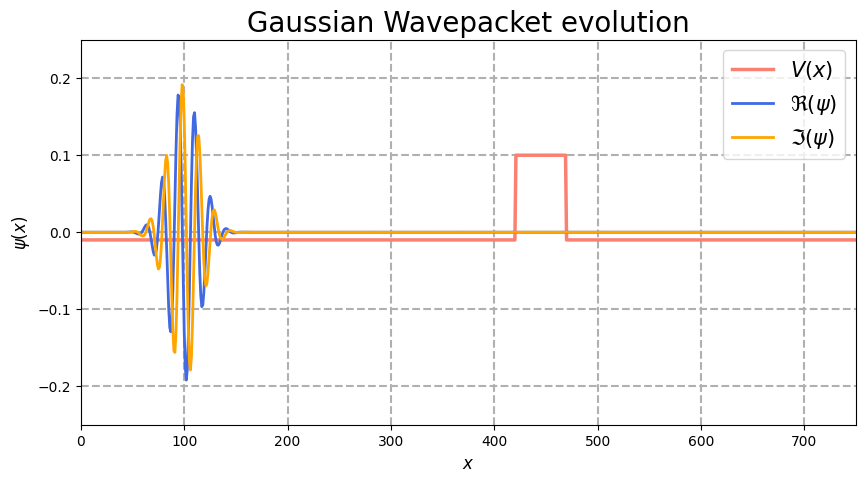

In [31]:
fig, ax = plt.subplots(figsize = (10,5))

def animate(i):   
    ax.clear()
        
    ax.plot(x[1:-1],V_flat, color="salmon", lw=2.5, label = '$V(x)$')
    ax.set_title('Gaussian Wavepacket evolution', fontsize = 20)
    ax.plot(x[1:-1],real_Psi[i],lw=2,color="royalblue", label = '$\Re(\psi)$')
    ax.plot(x[1:-1],imag_Psi[i],lw=2,color="orange", label = '$\Im(\psi)$')
    ax.legend(fontsize = 15)
    ax.set_xlabel('$x$', fontsize = 12)
    ax.set_ylabel(r'$\psi(x)$', fontsize=12)
    ax.set_xlim([0,N_grid])
    ax.set_ylim([-0.25, 0.25])
    ax.grid(ls="--", lw=1.5)

ani = FuncAnimation(fig, animate, frames=500, interval=10)
ani.save('quantum-tunneling-simulation.gif',writer='pillow',fps=50,dpi=100)